# Pre-workout

In [ ]:
#from google.colab import drive
from tensorflow.keras.preprocessing import image
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


target_shape = (256, 256)

In [ ]:
#drive.mount('/content/drive')

In [ ]:
class Dataset(object):
    def __init__(self, data_path):
        #path of the dataset
        self.data_path = data_path

        #class list
        self.data_classes = [directory for directory in os.listdir(data_path) if os.path.isdir(data_path+directory)]

        # init lists and dictionary
        self.images = []
        self.labels = []
        self.class_names = {}

        print(data_path)

        # for each class and for each image save the image and the label in the lists 
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            temp_images = os.listdir(temp_path)
            self.class_names[c] = c_name

            for i in temp_images:
                img_tmp = os.path.join(temp_path, i)

                if img_tmp.endswith('.jpg') or img_tmp.endswith('.JPEG'):

                    self.images.append(img_tmp)
                    self.labels.append(c)
                    

        print('Loaded {:d} images from {:s} '.format(len(self.images), self.data_path))



    def num_classes(self):
        # returns number of classes of the dataset
        return len(self.data_classes)
    
    def get_dataset(self):
        names = tf.data.Dataset.from_tensor_slices(self.images)
        ds = names.map(self.preprocess_image)
        return tf.data.Dataset.zip((names,ds)).batch(1).prefetch(8)
    
    def get_images(self):
        
        return list(map(self.preprocess_image, self.images))

    def make_triplets(self):


      anchors = []
      positive = []
      negative = []
      
      

      for img, classe in zip(self.images, self.labels):
          #current image 
          currentImage = img
          anchors.append(currentImage)

          #positive image 
          pos_idx = self.get_random_image_idx_same_class(classe)
          pos_img = self.images[pos_idx]
          positive.append(pos_img)

          #negative imahe
          neg_idx = self.get_random_image_idx_different_class( classe)
          neg_img = self.images[neg_idx]
          negative.append(neg_img)

      a = tf.data.Dataset.from_tensor_slices(anchors)
      p = tf.data.Dataset.from_tensor_slices(positive)
      n = tf.data.Dataset.from_tensor_slices(negative)

      dataset = tf.data.Dataset.zip((a,p,n))
      image_count = len(dataset)

      dataset = dataset.shuffle(buffer_size=1024)
      dataset = dataset.map(self.preprocess_triplets)

      train_dataset = dataset.take(round(image_count * 0.8))
      val_dataset = dataset.skip(round(image_count * 0.8))

      train_dataset = train_dataset.batch(32).prefetch(8)
      val_dataset = val_dataset.batch(32).prefetch(8)

        
      return (train_dataset, val_dataset)



    def get_random_image_idx_same_class(self, classe):

        label = 'formaggio'

        while label != classe:
            idx = np.random.choice(len(self.images))
            label = self.labels[idx]
        
        return idx

    def get_random_image_idx_different_class(self, classe):

        label = classe

        while label == classe:
            idx = np.random.choice(len(self.images))
            label = self.labels[idx]
        return idx

    def preprocess_image(self, filename):
        """
        Load the specified file as a JPEG image, preprocess it and
        resize it to the target shape.
        """
        
        image_string = tf.io.read_file(filename)
        #image = tf.image.decode_jpeg(image_string, channels=1)
        image = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, target_shape)
        return image


    def preprocess_triplets(self,anchor, positive, negative):
        """
        Given the filenames corresponding to the three images, load and
        preprocess them.
        """

        return (
            self.preprocess_image(anchor),
            self.preprocess_image(positive),
            self.preprocess_image(negative),
        )


      

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
       # positive_distance = K.square(anchor - positive)
        #negative_distance = K.square(anchor - negative)
        #positive_distance = np.sqrt(np.sum(positive_distance, axis=-1, keepdims=True))
        #negative_distance = np.sqrt(np.sum(negative_distance, axis=-1, keepdims=True))

        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
        #return (positive_distance, negative_distance)




In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

In [ ]:
def create_embedding():

    base_cnn = resnet.ResNet50(
        weights="imagenet", input_shape=target_shape + (3,), include_top=False
    )

    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    embedding = Model(base_cnn.input, output, name="Embedding")

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
    
    return embedding


# Model

## Dataset

In [ ]:
#training_path = '/content/drive/MyDrive/animals_dataset_the_ostriches/animals_dataset/training/'
#stupid_path = '/content/drive/MyDrive/stupid dataset/'

training_path = '/datasets/animali/animals_dataset_the_ostriches/unbalanced_dataset_2304/training/'

In [ ]:
tr, val = Dataset(data_path = training_path).make_triplets()

/datasets/animali/animals_dataset_the_ostriches/unbalanced_dataset_2304/training/
Loaded 31690 images from /datasets/animali/animals_dataset_the_ostriches/unbalanced_dataset_2304/training/ 


## Define siamese model

In [ ]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))
embedding = create_embedding()

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], 
    outputs=distances
)

## Train model

In [ ]:
#checkpoint_path = "/datasets/animali/checkpoints/deepnote/training_1/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)



#siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.01))
siamese_model.fit(tr.skip(100).take(1) ,epochs=10, validation_data = val.take(1))

Epoch 1/10


InvalidArgumentError: Graph execution error:

jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node DecodeJpeg_2}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_23550]

## Load Model

In [ ]:

checkpoint_path = "/datasets/animali/checkpoints/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.listdir(checkpoint_dir)
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

siamese_model = SiameseModel(siamese_network)

siamese_model.load_weights(latest)




## Visualize

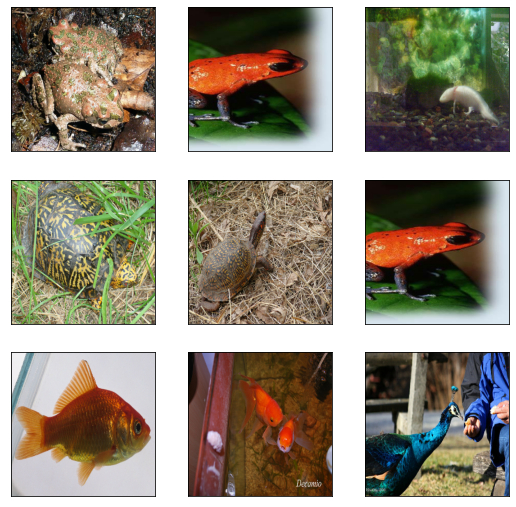

In [ ]:
sample = next(iter(tr))
visualize(*sample)



# Evaluate

## Check cosine similarity

check cosine similarity between anchor and positive and anchor and negative

In [ ]:
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

cosine_similarity = metrics.CosineSimilarity()


positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.98849493
Negative similarity 0.9865309


## Evaluate on test data 

In [ ]:
gallery_path = '/content/drive/MyDrive/animals_dataset_the_ostriches/galleria/'

query_path = "/content/drive/MyDrive/animals_dataset_the_ostriches/query/"

gallery = Dataset(data_path=gallery_path).get_dataset()
query = Dataset(data_path=query_path).get_dataset()


it = iter(query)



/content/drive/MyDrive/animals_dataset_the_ostriches/galleria/
Loaded 495 images from /content/drive/MyDrive/animals_dataset_the_ostriches/galleria/ 
Tensor("args_0:0", shape=(), dtype=string)
/content/drive/MyDrive/animals_dataset_the_ostriches/query/
Loaded 3 images from /content/drive/MyDrive/animals_dataset_the_ostriches/query/ 
Tensor("args_0:0", shape=(), dtype=string)


### map each gallery imgs to a similarity value 

In [ ]:
query_item = next(it)
sim = {}
b = embedding(resnet.preprocess_input(query_item[1]))

for name, img in gallery:
    a = embedding(resnet.preprocess_input(img))
    url = bytes.decode(name[0].numpy())

    similarity = cosine_similarity(a, b)
    sim[url] = float(similarity)
    


### sort the gallery

In [ ]:
sorted_gallery = list(sorted(sim.items(), key=lambda item: item[1])[::-1])[:16]

### Visualize query image

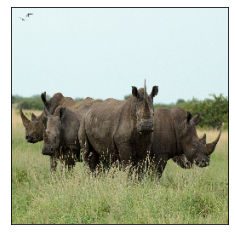

In [ ]:

plt.xticks([])
plt.yticks([])
plt.imshow(query_item[1][0], cmap=plt.cm.binary)
plt.grid(False)


### Visualize sorted gallery

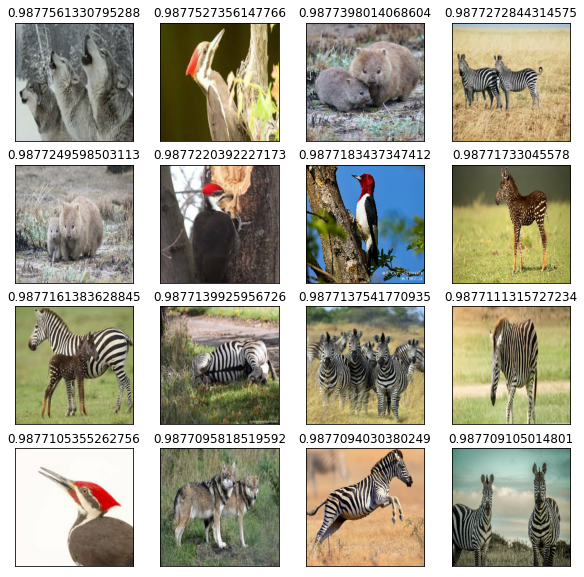

In [ ]:
plt.figure(figsize=(10,10))
for i, (path, simi) in enumerate(sorted_gallery):
    plt.subplot(4,4,i+1)
    image_string = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, cmap=plt.cm.binary)
    plt.grid(False)
    plt.title(simi)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93aceac2-8452-469e-8b02-c16d0438aa9c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>